21050111057
Mehmet Ali Yılmaz

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
# These are the mean and std values for CIFAR-100, used for normalization
mean = (0.5071, 0.4867, 0.4408)
std = (0.2675, 0.2565, 0.2761)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
# Load CIFAR-100 dataset , which has 100 classes
# The dataset is split into training and testing sets   
train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
# Create data loaders, one for training and one for testing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [ ]:
class ImprovedLeNet5(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()      
        self.features = nn.Sequential(
            # The first layer is a convolutional layer with 3 input channels (RGB), 32 output channels, and a kernel size of 3
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32), # This layer normalizes the output of the previous layer to improve training speed and stability
            nn.ReLU(inplace=True), # This layer applies the ReLU activation function to introduce non-linearity
            
            # The second layer is a convolutional layer with 32 input channels, 64 output channels, and a kernel size of 3
            # The padding=1 ensures that the output size is the same as the input size
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(2), # This layer reduces the spatial dimensions by half
            nn.Dropout(0.25), # This layer randomly sets 25% of the input units to 0 during training to prevent overfitting
            
            # The third layer is a convolutional layer with 64 input channels, 128 output channels, and a kernel size of 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
            # The fourth layer is a convolutional layer with 128 input channels, 256 output channels, and a kernel size of 3
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256), #
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1)), # This layer reduces the spatial dimensions to 1x1
        )
        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.view(x.size(0), -1)

In [ ]:
model = ImprovedLeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
    # Training the model
def train(model, data_loader, criterion, optimizer):
    model.train()   # Set the model to training mode
    total_loss, correct, total = 0.0, 0, 0 # Initialize variables to accumulate loss and correct predictions
    for images, labels in tqdm(data_loader, desc="Training", leave=False):
        outputs = model(images)
        loss = criterion(outputs, labels)   
        optimizer.zero_grad() # Zero the gradients before the backward pass
        loss.backward() # Backpropagation
        optimizer.step() # Update the model parameters
        total_loss += loss.item() * images.size(0) # Accumulate the loss
        # Calculate the accuracy
        _, preds = outputs.max(1) # Get the predicted class
        # Compare the predicted class with the true class
        correct += preds.eq(labels).sum().item() # Count the number of correct predictions
        # Calculate the total number of samples
        total += labels.size(0)     
    return total_loss / total, correct / total      

def validate(model, data_loader, criterion):
    model.eval() # Set the model to evaluation mode
    # Initialize variables to accumulate loss and correct predictions
    total_loss, correct, total = 0.0, 0, 0
    # Disable gradient calculation for validation   
    # This reduces memory consumption and speeds up computations
    # since we don't need to compute gradients during validation
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate the loss
            # Accumulate the loss
            total_loss += loss.item() * images.size(0) 
            _, preds = outputs.max(1)   # Get the predicted class
            correct += preds.eq(labels).sum().item() # Count the number of correct predictions
            total += labels.size(0) # Calculate the total number of samples
    return total_loss / total, correct / total

In [11]:
num_epochs = 20 # Number of epochs for training
train_losses, train_accuracies = [], [] 
val_losses, val_accuracies = [], []
# Loop through the number of epochs
# In each epoch, we train the model on the training set and validate it on the validation set
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, test_loader, criterion)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

Epoch 1/20 | Train Loss: 3.5714, Acc: 0.1534 | Val Loss: 3.2451, Acc: 0.2042


Epoch 2/20 | Train Loss: 2.9196, Acc: 0.2644 | Val Loss: 2.7249, Acc: 0.3018


Epoch 3/20 | Train Loss: 2.6037, Acc: 0.3308 | Val Loss: 2.5678, Acc: 0.3370


Epoch 4/20 | Train Loss: 2.3879, Acc: 0.3728 | Val Loss: 2.3957, Acc: 0.3773


Epoch 5/20 | Train Loss: 2.2225, Acc: 0.4137 | Val Loss: 2.2172, Acc: 0.4169


Epoch 6/20 | Train Loss: 2.0987, Acc: 0.4422 | Val Loss: 2.0756, Acc: 0.4488


Epoch 7/20 | Train Loss: 1.9916, Acc: 0.4647 | Val Loss: 2.0475, Acc: 0.4553


Epoch 8/20 | Train Loss: 1.9141, Acc: 0.4816 | Val Loss: 1.9601, Acc: 0.4773


Epoch 9/20 | Train Loss: 1.8489, Acc: 0.4979 | Val Loss: 1.9339, Acc: 0.4838


Epoch 10/20 | Train Loss: 1.7852, Acc: 0.5106 | Val Loss: 1.8193, Acc: 0.5072


Epoch 11/20 | Train Loss: 1.7289, Acc: 0.5273 | Val Loss: 1.8069, Acc: 0.5130


Epoch 12/20 | Train Loss: 1.6789, Acc: 0.5364 | Val Loss: 1.7705, Acc: 0.5250


Epoch 13/20 | Train Loss: 1.6370, Acc: 0.5477 | Val Loss: 1.8802, Acc: 0.4991


Epoch 14/20 | Train Loss: 1.5895, Acc: 0.5617 | Val Loss: 1.7291, Acc: 0.5371


Epoch 15/20 | Train Loss: 1.5540, Acc: 0.5689 | Val Loss: 1.7642, Acc: 0.5274


Epoch 16/20 | Train Loss: 1.5174, Acc: 0.5777 | Val Loss: 1.6856, Acc: 0.5431


Epoch 17/20 | Train Loss: 1.4915, Acc: 0.5838 | Val Loss: 1.6800, Acc: 0.5451


Epoch 18/20 | Train Loss: 1.4597, Acc: 0.5908 | Val Loss: 1.6520, Acc: 0.5493


Epoch 19/20 | Train Loss: 1.4335, Acc: 0.5979 | Val Loss: 1.6735, Acc: 0.5489


Epoch 20/20 | Train Loss: 1.4070, Acc: 0.6040 | Val Loss: 1.6277, Acc: 0.5567


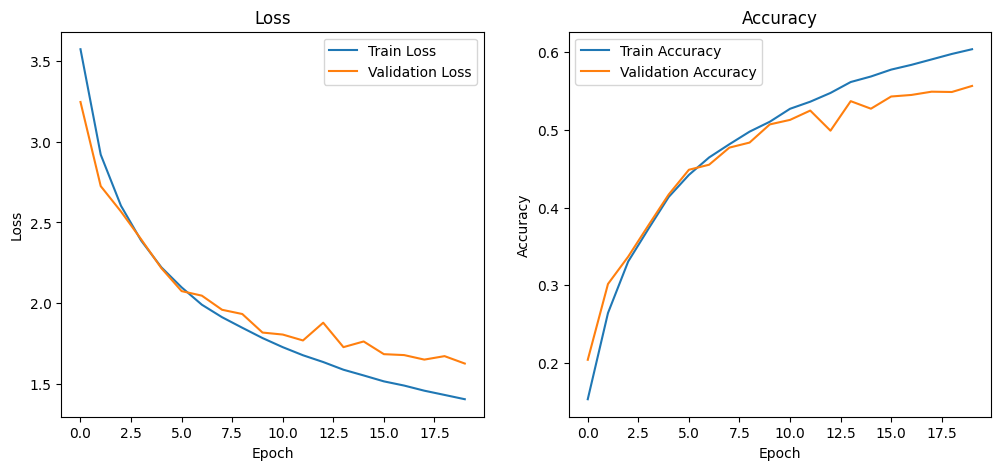

In [12]:
# Plotting the training and validation loss and accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()